In [1]:
/pwd

'/Users/monica/Documents/프로젝트/Bone Age/노트북'

In [1]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
import math
%matplotlib inline

#cv
import cv2
import math
from PIL import Image
import math
from scipy import ndimage
import argparse
import imutils

#시각화
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

from matplotlib import font_manager, rc
rc('font',family="AppleGothic")
plt.rcParams["font.family"]="AppleGothic" #plt 한글꺠짐
plt.rcParams["font.family"]="Arial" #외국어꺠짐
plt.rcParams['axes.unicode_minus'] = False # 마이너스 부호 출력 설정
plt.rc('figure', figsize=(10,8))

sns.set(font="AppleGothic", 
        rc={"axes.unicode_minus":False},
        style='darkgrid') #sns 한글깨짐

In [2]:
org_img_path='/Users/monica/Documents/프로젝트/Bone Age/Bone_age/01_RawData/01_data/'
bit_mask_img_path ='/Users/monica/Documents/프로젝트/Bone Age/Bone_age/test/01_bit_mask_test/'
cut_img_path = '/Users/monica/Documents/프로젝트/Bone Age/Bone_age/test/02_cut_test/'
rotation_path ='/Users/monica/Documents/프로젝트/Bone Age/Bone_age/test/03_rotation/'
rotation_cropped_path = '/Users/monica/Documents/프로젝트/Bone Age/Bone_age/test/04_rotation_cropped/'
contrast_path = '/Users/monica/Documents/프로젝트/Bone Age/Bone_age/test/05_roi_contrast/'
resized_contrast_path ='/Users/monica/Documents/프로젝트/Bone Age/Bone_age/test/05_1_roi_contrast(resized)/'

In [3]:
img_org = cv2.imread(org_img_path+'org001.jpg')
img_org2 = cv2.imread(org_img_path+'org002.jpg')
img_org3 = cv2.imread(org_img_path+'org003.jpg')
rot_img1 = cv2.imread(rotation_path+'rot_001.jpg')
rot_img2 = cv2.imread(rotation_path+'rot_002.jpg')
rot_img3 = cv2.imread(rotation_path+'rot_003.jpg')

img_rot2 = rot_img2.copy()

In [5]:
#이미지 함수
def show(img):
    #사이즈
    plt.figure(figsize = (10,8))
    #xticks/yticks - 눈금표
    plt.xticks([])
    plt.yticks([])
    #코랩에서 안돌아감 주의
    plt.imshow(img, cmap= 'gray')
    plt.show()

### 손목자르기

(1057, 759, 3)


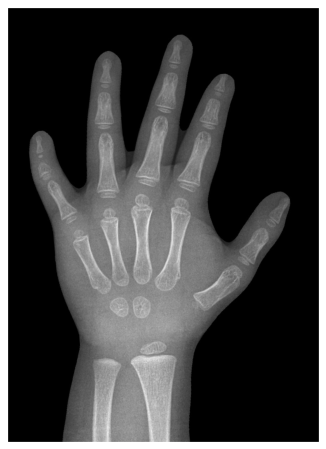

In [7]:
rot_img1 = cv2.imread(rotation_path+'rot_002.jpg')
img = rot_img1.copy()

height = img.shape[0]
width = img.shape[1]

#이미지의 아래에서부터 시작해서 화소 평균이 커지는(밝아지는) 경계선 찾기
start = int(height*0.95)  #아래 테두리가 밝은 경우를 고려해서 height*0.95부터 시작함
index = 0
k = 10 #10개 행씩 평균 구함
while True:
    pixel_lower = img[start-k*(index+1):start-k*index,:].mean()
    pixel_upper = img[start-k*(index+2):start-k*(index+1),:].mean()
    if pixel_upper - pixel_lower > 0:
        end_y = start-k*(index+1)
        break
    index += 1
    
img_center = img[:end_y]
rot_img1 = rot_img1[:end_y]
img_color = rot_img1.copy()
print(img_center.shape)
show(img_center)

### 센터값

(1057, 759, 3)


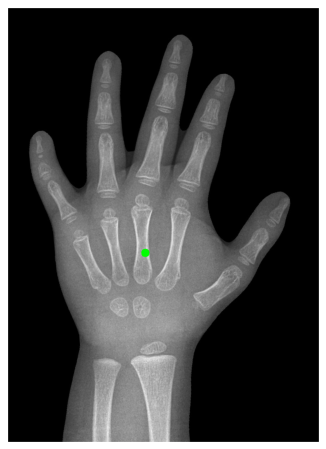

In [8]:
img_center = cv2.cvtColor(img_center, cv2.COLOR_BGR2GRAY)
res, thresh = cv2.threshold(img_center, img_center.mean(), 255, cv2.THRESH_BINARY)

# find contours in the thresholded image
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

# loop over the contours
for c in cnts:
	# compute the center of the contour
	M = cv2.moments(c)
	cX = int(M["m10"] / M["m00"])
	cY = int(M["m01"] / M["m00"])
	# draw the contour and center of the shape on the image
	cv2.drawContours(img_center, [c], -1, (0, 255, 0), 2)
	cv2.circle(img_color, (cX, cY), 10, (0, 255, 0), -1)
    
# cv2.line(img_color,(cX, cY) ,(width, cY), (255, 0, 0), 3)

print(img_color.shape)
show(img_color)

### 손가락포인트

(1057, 759, 3)


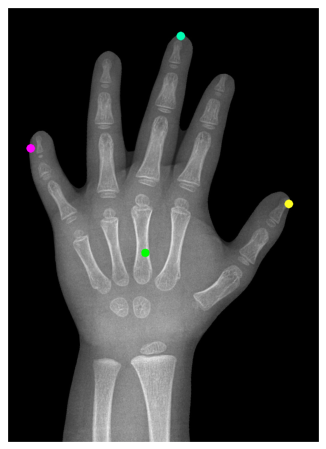

In [10]:
img_test = img_color.copy()

contours, hierarchy = cv2.findContours(img_center, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
max_cnt = max(contours, key=cv2.contourArea)
hull = cv2.convexHull(max_cnt, returnPoints = False)
defects = cv2.convexityDefects(max_cnt, hull)

start_list = []
far_list = []
for i in range(defects.shape[0]):
    s,e,f,d = defects[i,0]
    start = tuple(max_cnt[s][0])
    end = tuple(max_cnt[e][0])
    far = tuple(max_cnt[f][0])
    far_list.append(far)

#     cv2.circle(img_test, far, 3, (255, 200, 3), 10)
   
    ##중지 
    for i in far_list:
        far_list.sort(key= lambda x:x[1])
        top = far_list[0]
        tX, tY = top
#         cX, cY = center
        
        cv2.circle(img_test, top, 5, (2, 255, 180),10)
        
#손목 오른쪽 hull값
far_list.sort(key =lambda x:x[1])
wrist_point =[]
for i in far_list:
    if i[1] > cY:
        wrist_point.append(i)
        wrist_point.sort(key = lambda x:x[1])
        wRX, wRY  = wrist_point[0]
        

#새끼 손가락        
far_list.sort(key= lambda x:x[0])
pinky_list = []
for i in far_list:
    if i[1] < cY and i[0] < cX:
        pinky_list.append(i)
pinky_list.sort(key= lambda x:x[0])
pinky = pinky_list[0]
cv2.circle(img_test,pinky, 5,(255,0,255),10)
            
# 엄지손가락
far_list.sort(key= lambda x:x[0])
thumbs = far_list[-1]
cv2.circle(img_test,thumbs, 5,(255,255,35),10)

print(img_test.shape)    
show(img_test)